In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [3]:
structure_names = ["Ge-1_Se-1", "Ge-1_Te-1", "Ge-1_Sb-1"]
encoding = "atomic"

In [4]:
df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f"{struct_name}_{encoding}.csv"), index_col=0) for struct_name in structure_names])

In [5]:
cols_raw = list(df.columns)
cols_trash = ['converged', 'accuracy']
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [6]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent])

In [7]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,Ag,Al,Ar,As,Au,B,Ba,...,Ti,Tl,Tm,V,W,Xe,Y,Yb,Zn,Zr
count,1898.000000,1898.000000,1898.000000,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,...,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0,1898.0
mean,242.781876,0.229053,57.460485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,90.008234,0.145466,23.389164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,100.000000,0.100000,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,180.000000,0.125000,35.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,260.000000,0.166667,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,340.000000,0.250000,75.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,380.000000,0.500000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train-Test-Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [9]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [10]:
rf_model = RandomForestRegressor()

### Packing them together to reduce code size

In [11]:
models = {"Augmented Linear Regression": linear_augmented_model, "Random Forest": rf_model}

# Model training

In [12]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...


<ipython-input-12-f12d51c6d413>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Done!



# Model evaluation

In [13]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:2.2075E-02	test:2.1059E-02
MAPE:	train:9.5363E+11	test:5.7017E+02
Done!

Evaluating Random Forest...
MSE:	train:1.2491E-07	test:3.2700E-07
MAPE:	train:4.5267E+07	test:2.1833E-02
Done!



# Visualization

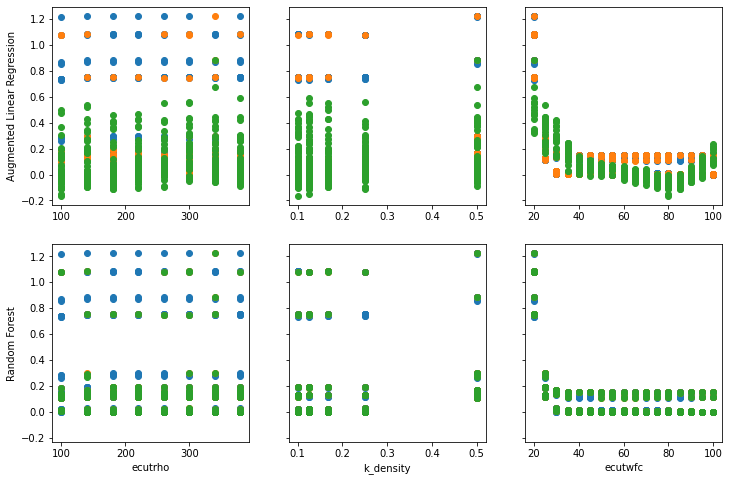

In [14]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

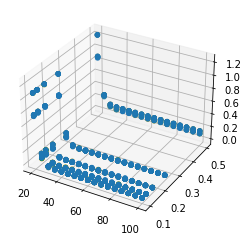

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [16]:
def log_transform(y, miny, eps=10E-15):
    return np.log(y - miny + eps)

def inv_log_transform(logy, miny, eps=10E-15):
    return np.exp(logy) + miny - eps

miny = float(np.min(y_raw))
maxy = float(np.max(y_raw))

y_raw_s = np.array(y_raw.squeeze())
miny2 = np.sort(list(set(list(y_raw_s))))[1]
eps = (miny2 - miny)/10

    

logy_raw = log_transform(y_raw, miny, eps)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

In [17]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [18]:
rf_log_model = RandomForestRegressor()

In [19]:
models = {"Augmented Linear Regression - Log": linear_log_augmented_model, "Random Forest - Log": rf_log_model}

In [20]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...


<ipython-input-20-53ec1858a53a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, logy_train)


Done!



In [21]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    y_train = inv_log_transform(logy_train.squeeze(), miny, eps)
    y_test = inv_log_transform(logy_test.squeeze(), miny, eps)

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:1.9259E+00	test:1.2732E+00
MSE:	train:5.4336E-02	test:4.3312E-02
MAPE:	train:8.1798E-01	test:6.9206E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:1.3803E-02	test:2.0902E-02
MSE:	train:1.4224E-07	test:3.9001E-07
MAPE:	train:3.3821E-03	test:8.2739E-03
Done!



Text(0.5, 0, 'ecutwfc')

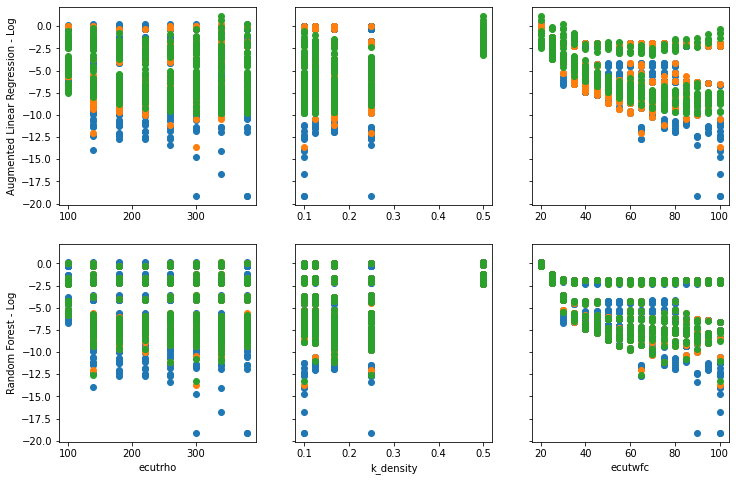

In [22]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Find best parameters for a given error

In [23]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo

In [24]:
def delta_E_prediction(x, model):
    # get Ge and Te column index
    Ge_idx = X_raw.columns.get_loc("Ge")
    Te_idx = X_raw.columns.get_loc("Te")

    input = np.zeros(X_raw.shape[1])
    input[0:3] = x
    input[Ge_idx] = 0.5
    input[Te_idx] = 0.5
    return model.predict(input.reshape(1,-1))[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = x[1]
    ecutwfc = x[2]
    return ecutrho + 1 / k_density + ecutwfc

In [25]:
x_0 = [100, .1, 100]
max_delta_E = 1e-1
model = linear_augmented_model

print(delta_E_prediction(x_0, model))

res = minimize(complexity, x0=x_0, bounds=[(1,10000), (1e-16,0.5), (1,10000)],
    constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
                 {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
    options={'maxiter': 100},
)
print(res)

print(delta_E_prediction(res.x, model))

# code below doesn't work
# nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))
# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

[0.15938092]
     fun: 186.88603028745598
     jac: array([ 1., -4.,  1.])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 11
    njev: 10
  status: 0
 success: True
       x: array([91.52786202,  0.5       , 93.35816827])
[0.04219342]
